In [1]:
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval import metrics
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler

In [2]:
class WineNN(nn.Module):
    def __init__(self, num_features, hidden_size, output_size):
        super(WineNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x)
        return x

In [3]:
from sklearn.utils import shuffle

random_shuffle_state = 2024


def shuffle_train_valid_test_split(dataset: TensorDataset, valid_p=0.1, test_p=0.3):
    dataset = TensorDataset(
        *shuffle(*dataset.tensors, random_state=random_shuffle_state))

    train_offset = int(len(dataset) * (1 - (test_p + valid_p)))
    valid_offset = int(len(dataset) * valid_p) + train_offset

    return {
        "train": TensorDataset(*dataset[:train_offset]),
        "valid": TensorDataset(*dataset[train_offset:valid_offset]),
        "test":  TensorDataset(*dataset[valid_offset:])
    }

In [4]:
# import breast cancer & wine datasets
wine = fetch_ucirepo(id=109)

In [5]:
wine_scaler = StandardScaler()
wine_dataset = TensorDataset(
    torch.tensor(wine_scaler.fit_transform(wine.data.features), dtype=torch.float),
    torch.tensor(wine.data.targets.to_numpy() - 1).flatten()
)

wine_datasets = shuffle_train_valid_test_split(wine_dataset)

In [6]:
datasets = wine_datasets

model = WineNN(wine.data.features.shape[1], 64, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

In [7]:
losses = []
val_accuracy = []
val_losses = []

train_samples = len(datasets["train"])
val_samples = len(datasets["valid"])

train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

for epoch in range(20):
    running_loss = 0.0

    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    losses.append(running_loss / train_samples)

    model.eval()
    with torch.no_grad():
        inputs, targets = datasets["valid"][:]
        outputs = model(inputs)

        acc = metrics.functional.multiclass_accuracy(outputs, targets)
        loss = criterion(outputs, targets)

        val_accuracy.append(acc)
        val_losses.append(loss / val_samples)

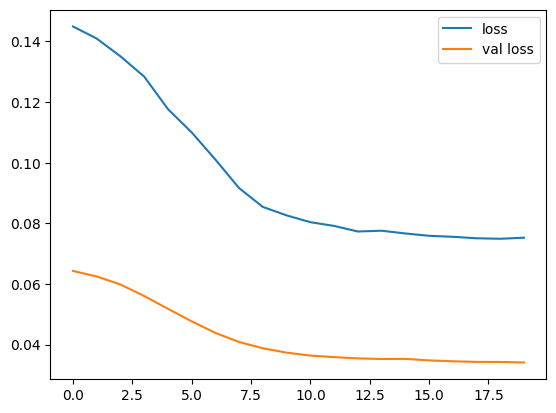

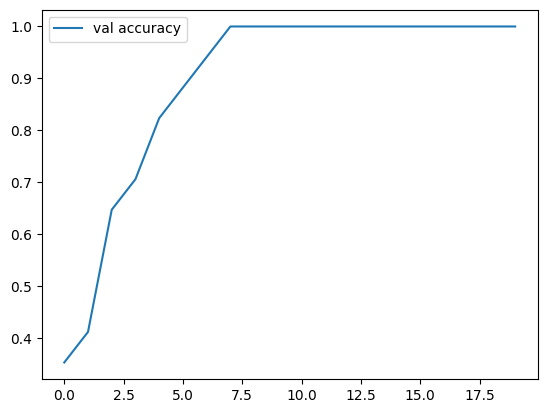

In [8]:
plt.plot(losses, label="loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

plt.plot(val_accuracy, label="val accuracy")
plt.legend()
plt.show()

In [9]:
import SALib
import SALib.sample.finite_diff
import SALib.analyze.dgsm


def wrapped_model(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float)
    with torch.no_grad():
        return model(inputs).detach().numpy()


problem = SALib.ProblemSpec({
    "num_vars": len(wine.data.headers[:-1]),
    "names": wine.data.headers[:-1].to_list(),
    "bounds": [[-1., 1.]] * len(wine.data.headers[:-1]),
})

problem.items()

problem.sample(SALib.sample.finite_diff.sample, N=1024)
problem.evaluate(wrapped_model)
problem.analyze(SALib.analyze.dgsm.analyze)

problem

Samples:
	13 parameters: ['Alcohol', 'Malicacid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue', '0D280_0D315_of_diluted_wines', 'Proline']
	14336 samples
Outputs:
	3 outputs: ['Y1', 'Y2', 'Y3']
	14336 evaluations
Analysis:
Y1:
                                    vi    vi_std      dgsm  dgsm_conf
Alcohol                       0.037044  0.062251  0.175125   0.003787
Malicacid                     0.003045  0.007145  0.014393   0.000493
Ash                           0.023001  0.038345  0.108739   0.002390
Alcalinity_of_ash             0.032188  0.045885  0.152169   0.002991
Magnesium                     0.055436  0.087756  0.262075   0.005304
Total_phenols                 0.027880  0.043504  0.131802   0.002523
Flavanoids                    0.023737  0.041868  0.112219   0.002495
Nonflavanoid_phenols          0.039908  0.055057  0.188665   0.003243
Proanthocyanins               0.002469  0.005656